In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bemcs

['left_topo' 'ramp_mft' 'right_topo' 'topo']


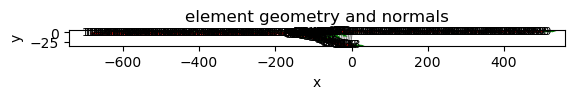

In [58]:
# Elastic parameters
mu = 1
nu = 0.25

# read fault geometry files
fileinput = pd.read_csv("mht_geometry.csv")

# print(fileinput.head())
x1 = fileinput["x1"].values
x2 = fileinput["x2"].values
y1 = fileinput["y1"].values
y2 = fileinput["y2"].values
bc_x = fileinput["bc_x"].values
bc_y = fileinput["bc_y"].values
bctype_x = fileinput["bc_type_x"].values
bctype_y = fileinput["bc_type_y"].values

labels = fileinput["collection"].values
print(np.unique(labels))

# create bemcs data structure
els = bemcs.initialize_els()
els.x1 = x1
els.y1 = y1
els.x2 = x2
els.y2 = y2
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
faultid = np.arange(n_els)
bemcs.plot_els_geometry(els)

## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [59]:
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Number of open nodes = 3
: [array([357]), array([356]), array([659])]
Number of 2-overlap nodes = 316
: [array([ 360, -359]), array([ 363, -362]), array([ 366, -365]), array([ 369, -368]), array([ 372, -371]), array([ 375, -374]), array([ 378, -377]), array([ 381, -380]), array([ 384, -383]), array([ 387, -386]), array([ 390, -389]), array([ 393, -392]), array([ 396, -395]), array([ 399, -398]), array([ 402, -401]), array([ 405, -404]), array([ 408, -407]), array([ 411, -410]), array([ 414, -413]), array([ 417, -416]), array([ 420, -419]), array([ 423, -422]), array([ 426, -425]), array([ 429, -428]), array([ 432, -431]), array([ 435, -434]), array([ 438, -437]), array([ 441, -440]), array([ 444, -443]), array([ 447, -446]), array([ 450, -449]), array([ 453, -452]), array([ 456, -455]), array([ 459, -458]), array([ 462, -461]), array([ 465, -464]), array([ 468, -467]), array([ 471, -470]), array([ 474, -473]), array([ 477, -476]), array([ 480, -479]), array([ 483, -482]), array([ 486, 

In [60]:
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# apply BCs at central nodes
BC_c[0::2, 0] = bc_x
BC_c[1::2, 0] = bc_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

## Design Matrix System 
- At element centers, we implement either displacement or traction boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we implement 2 equations for conservation of slip and 4 equations for smoothness

We first deal with the matrix system for the central nodes

In [61]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, reference="local"
)

# Patch center locations
# (need to be shifted an infinitesimal amount in unit normal direction for displacement bcs)
epsilonr = 1e-4 * (bctype_x == "u_global").astype(float)
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = (obs_xy[:, 0] + epsilonr * els.x_normals).reshape(-1, 1)
y_obs = (obs_xy[:, 1] + epsilonr * els.y_normals).reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="local")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="local")

### Assemble linear operator for central nodes only

In [62]:
# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

# x,y-kernels
for i in np.unique(labels):
    index = np.where(labels == i)[0]
    for j in index:
        if bctype_x[j] == "u_global":
            for k in range(0, 3):
                kerneleval_x[j, k::6] = kernels_s[3][j, k::3]
                kerneleval_x[j, k + 3 :: 6] = kernels_n[3][j, k::3]
        elif bctype_x[j] == "t_local":
            for k in range(0, 3):
                kerneleval_x[j, k::6] = traction_kernels_s[0][j, k::3]
                kerneleval_x[j, k + 3 :: 6] = traction_kernels_n[0][j, k::3]
        elif bctype_x[j] == "s_local":
            kerneleval_x[j, :] = matrix_slip[2::6, :][j, :]
        else:
            raise ValueError("unrecognized boundary condition type")

        if bctype_y[j] == "u_global":
            for k in range(0, 3):
                kerneleval_y[j, k::6] = kernels_s[4][j, k::3]
                kerneleval_y[j, k + 3 :: 6] = kernels_n[4][j, k::3]
        elif bctype_y[j] == "t_local":
            for k in range(0, 3):
                kerneleval_y[j, k::6] = traction_kernels_s[1][j, k::3]
                kerneleval_y[j, k + 3 :: 6] = traction_kernels_n[1][j, k::3]
        elif bctype_y[j] == "s_local":
            kerneleval_y[j, :] = matrix_slip[3::6, :][j, :]
        else:
            raise ValueError("unrecognized boundary condition type")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

### Open nodes, overlapping nodes & triple junctions

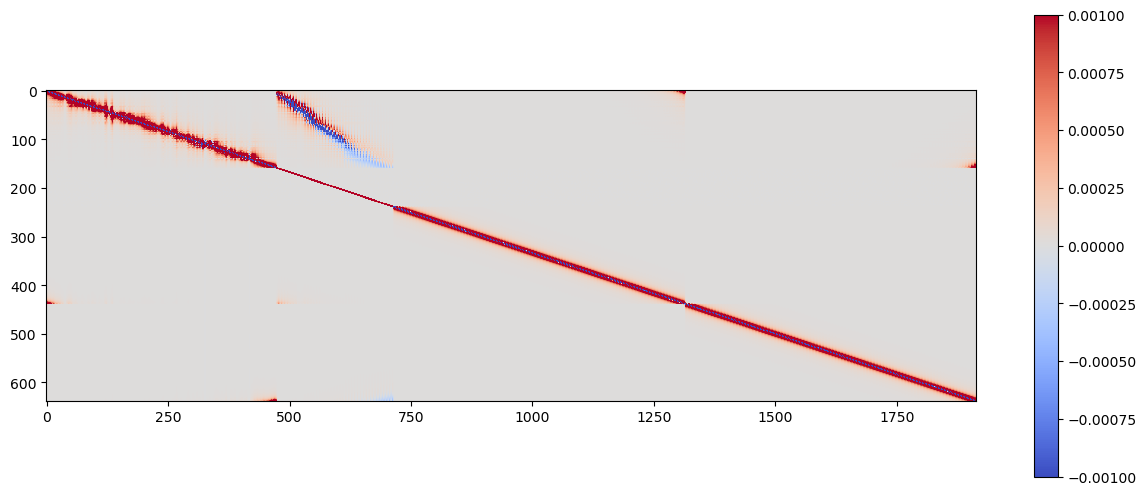

In [63]:
matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
# plot design matrix
plt.figure(figsize=(15, 6))
plt.imshow(matrix_system_c, cmap="coolwarm")
plt.colorbar()
plt.clim(-0.001, 0.001)
plt.show()

# Solve system

In [64]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

Linear Operator Condition Number: 30592.836386657043


## Plot displacement and stress components at the surface

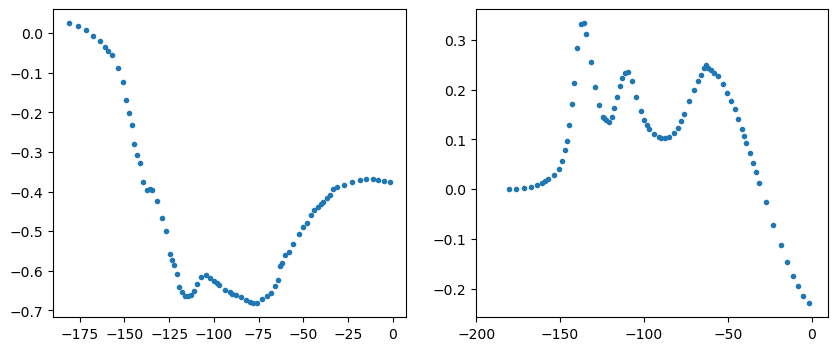

In [ ]:
# Observation points
# n_obs = 100
x_obs = (els.x_centers - els.x_normals * 1e-6)[labels == "topo"]
y_obs = (els.y_centers - els.y_normals * 1e-6)[labels == "topo"]
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Compute displacement and stresses (we will plot it later)
ux, uy, _, _, _ = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux, ".")
plt.xlabel("x [km]")
plt.ylabel("$v_x$")
plt.xlim([-200, 10])
plt.subplot(1, 2, 2)
plt.plot(x_obs, uy, ".")
plt.xlim([-200, 10])
plt.show()

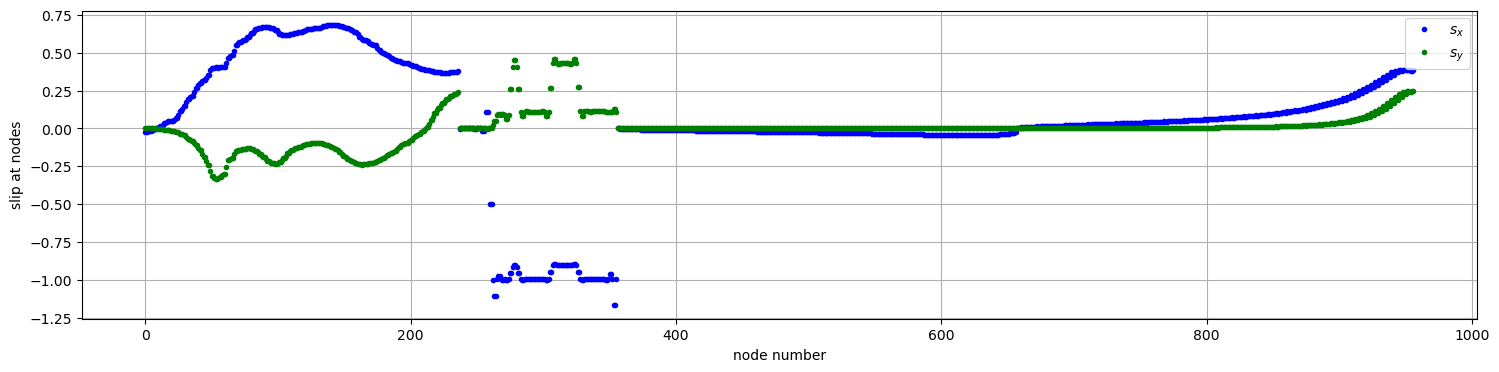

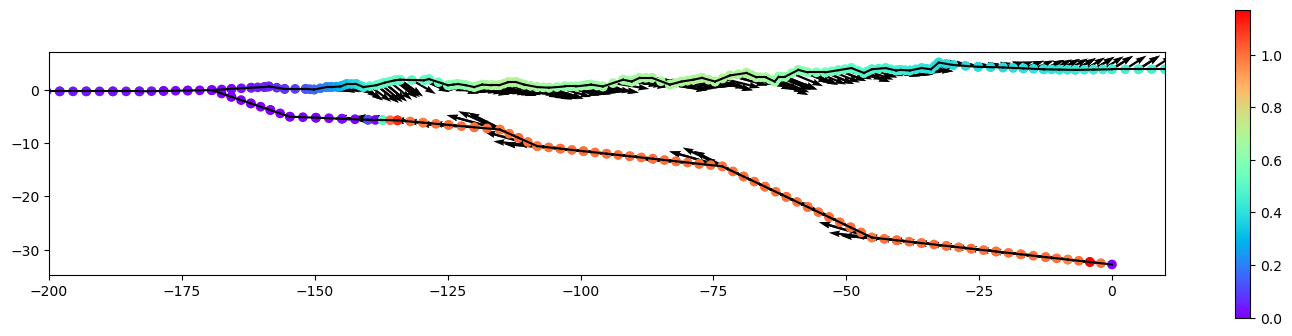

In [66]:
# Extract slip at nodes from quadratic coefficients
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, reference="global"
)
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x, slip_nodes_y))
xnodes = np.zeros((3 * n_els, 1))
ynodes = np.zeros((3 * n_els, 1))
xnodes[0::3, 0] = els.x1
xnodes[2::3, 0] = els.x2
xnodes[1::3, 0] = els.x_centers
ynodes[0::3, 0] = els.y1
ynodes[2::3, 0] = els.y2
ynodes[1::3, 0] = els.y_centers

plt.figure(figsize=(18, 4))
plt.plot(slip_nodes_x, "b.", label="$s_x$")
plt.plot(slip_nodes_y, "g.", label="$s_y$")
plt.xlabel("node number")
plt.ylabel("slip at nodes")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(18, 4))
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.quiver(xnodes, ynodes, slip_nodes_x, slip_nodes_y, scale=20, width=0.002)
plt.scatter(
    xnodes,
    ynodes,
    c=np.sqrt(slip_nodes_x**2 + slip_nodes_y**2),
    label="Data Points",
    marker="o",
    cmap="rainbow",
)
plt.xlim([-200, 10])
plt.gca().set_aspect("equal", adjustable="box")
plt.colorbar()
plt.show()